In [1]:
include("/home/n/nichollsh/lovepy/TidalLoveNumbers.jl")
using .TidalLoveNumbers
using Plots

# Get precision of Love number module (e.g., Float64, Double64, etc)
prec = TidalLoveNumbers.prec;    # Type of real numbers
precc = TidalLoveNumbers.precc;  # TYpe of complex numbers

In [2]:
gr()

Plots.GRBackend()

# Total Heating Rate

In [3]:
function once(day, ecc, visc; shear=60.0, bulk=260.0)

    # Rotational and orbital parameters
    ω = 2 * pi / (day * 24 * 60 * 60)     # Orbital frequency (2π / orbital period)

    # Internal structure:
    # First element is the innermost layer, last element is the outermost layer

    # Create a toy, homogeneous Enceladus-ish model
    ρ = prec[4300, 4300, 4300, 4300]  # Bulk density of each layer (kg m^-3)
    r = prec[3,                             # Radii of each boundary (km)
             4,                             # Radius of CMB. If no core, set this to a 1km.
             5,
             5.5,
             6.0] .* 1e6                  # Outer radius of solid surface
    μ = prec[shear, shear, shear, shear] .* 1e9         # Elastic shear modulus of each layer (Pa)
    κ = prec[bulk, bulk, bulk, bulk] .* 1e16    # Bulk modulus of each layer (set to a large number for incompressible material) (GPa)
    η = prec[visc, visc, visc, visc]        # Shear viscosity of each layer (Pa s)

    μc = 1im * μ*ω ./ (1im*ω .+ μ./η)       # Complex shear modulus for a Maxwell material. Change this for different rheologies.

    R = r[end]

    rr = expand_layers(r, nr=40)            # Expand the layers to a finer grid for numerical integration
    g = get_g(rr, ρ);                       # Get the gravitational acceleration on the fine grid

    tidal_solution = calculate_y(rr, ρ, g, μc, κ)       # Get "y-functions"

    k2 = tidal_solution[5, end, end] - 1               # Get k2 Tidal Love Number

    Edot = get_bulk_heating(tidal_solution, ω, R, ecc) # Get total power output in watts

    Mpl = 0.0
    for (i,v) in enumerate(ρ)
        ro = r[i+1]
        ri = r[i]
        Mpl += ρ[i] * (4 * pi / 3) * (ro-ri) * (ro^2 + ro*ri + ri^2)
    end

    # println(Mpl)

    return Edot / Mpl
end

once (generic function with 1 method)

## Power vs eccentricity

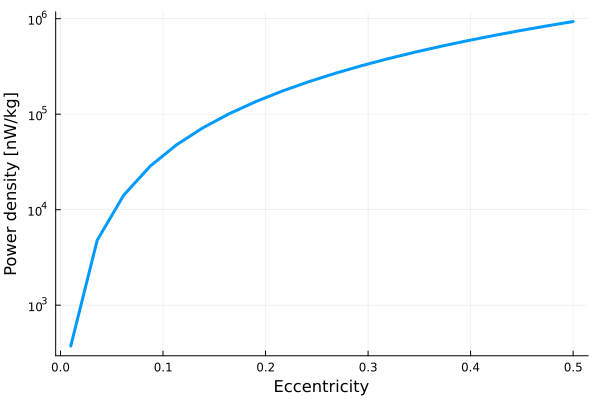

In [4]:
x_arr = collect(Float64, range(0.01, 0.5, length=20))
y_arr = zeros(Float64, length(x_arr))

for (i,x) in enumerate(x_arr)
    y_arr[i] = once(2.5, x, 1e15) * 1e9
end

plt = plot(xlabel="Eccentricity", ylabel="Power density [nW/kg]", yscale=:log10)
plot!(plt, x_arr, y_arr, label="", lw=3)
display(plt)

## Power vs period

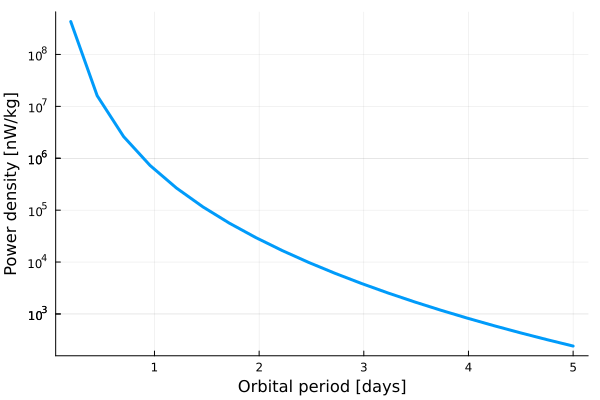

In [12]:
x_arr = collect(Float64, range(0.2, 5.0, length=20))
y_arr = zeros(Float64, length(x_arr))

for (i,x) in enumerate(x_arr)
    y_arr[i] = once(x, 0.05, 1e15) * 1e9
end

ymin = minimum(y_arr)/1.5
ymax = maximum(y_arr)*1.5
yticks = 10.0 .^ ceil.(range(log10(ymin), log10(ymax), 10))

plt = plot(xlabel="Orbital period [days]", ylabel="Power density [nW/kg]", yscale=:log10, yticks=yticks)
plot!(plt, x_arr, y_arr, label="", lw=3)
display(plt)

## Power vs viscosity

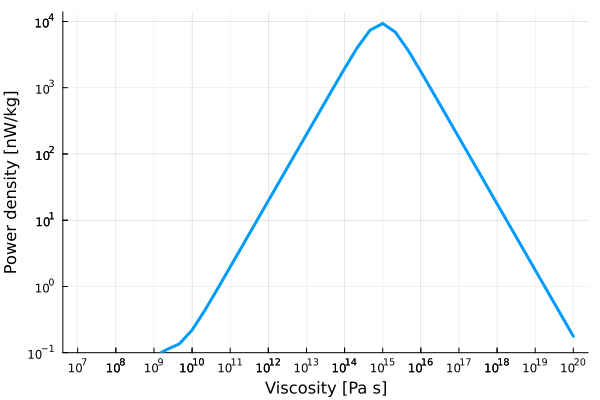

In [10]:
x_arr = collect(Float64, 10.0 .^ range(7, 20, length=40))
y_arr = zeros(Float64, length(x_arr))


for (i,x) in enumerate(x_arr)
    y_arr[i] = once(2.5, 0.05, x) * 1e9
end

ymin = 0.1
ymax = maximum(y_arr)*1.5
yticks = 10.0 .^ ceil.(range(log10(ymin), log10(ymax), 10))

plt = plot(xlabel="Viscosity [Pa s]", ylabel="Power density [nW/kg]",
                yscale=:log10, xscale=:log10, ylims=(ymin, ymax), yticks=yticks)
plot!(plt, x_arr, y_arr, label="", lw=3)
xticks!(plt, 10. .^ round.(log10.(x_arr[begin:2:end])))
display(plt)

## Power vs viscosity, period

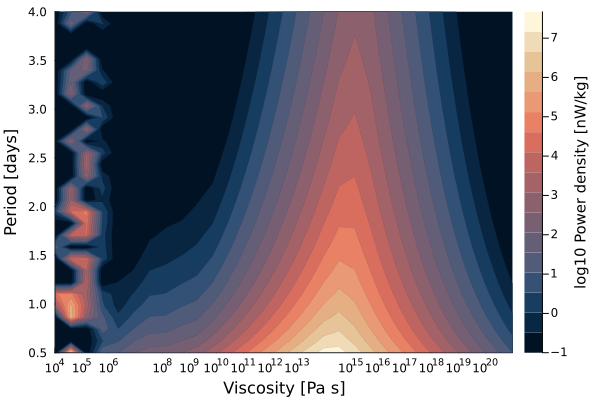

"/home/n/nichollsh/analysis/cmap.pdf"

In [7]:
x_inp = collect(Float64, 10.0 .^ range(4,  21,  length=30))
y_inp = collect(Float64,         range(0.5, 4.0, length=30))

x_arr = zeros(Float64, (length(x_inp), length(y_inp)))
y_arr = zeros(Float64, size(x_arr))
z_arr = zeros(Float64, size(x_arr))

z_min = 0.1

for (i,x) in enumerate(x_inp)
    for (j,y) in enumerate(y_inp)
        x_arr[i,j] = x
        y_arr[i,j] = y

        z = once(y, 0.05, x) * 1e9
        z_arr[i,j] = log10(max(z,z_min))
    end
end

plt = plot(xlabel="Viscosity [Pa s]", ylabel="Period [days]",
            xscale=:log10, colorbar_title="log10 Power density [nW/kg]")
contourf!(plt, x_inp, y_inp, z_arr', label="", cmap=:lipari, lw=0, levels=16)

xticks!(plt, 10. .^ round.(log10.(x_inp[begin:2:end])))
# scatter!(plt, x_arr, y_arr, marker_z=z_arr, cmap=:lipari, label="", msw=0.8, msc=:white,)
display(plt)
savefig(plt, "cmap.pdf")